In [37]:
%matplotlib inline
from xgboost import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn import preprocessing
from collections import Counter
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
#Tp ignore python warnings
import pytz
from datetime import datetime
from pytz import timezone
from zipline.api import order, symbol, symbols, record, order_target, history , schedule_function
from zipline.utils.events import date_rules
'''
order() takes 2 arguments : i) a security object ii) no. of shares you want to buy
record() helps you to save values of variables at each iteration
'''
from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_bars_from_yahoo
#from zipline import run_algorithm
import matplotlib.pyplot as plt

In [2]:
assign_stock = ['AAPL']
start = datetime(2015,12,1,0,0,0,0, pytz.utc).date()
end = datetime(2016,12,1,0,0,0,0, pytz.utc).date()
#data = load_bars_from_yahoo(stocks=['SPY'], start=start,end=end)
input_data = load_bars_from_yahoo(stocks=assign_stock, start=start,end=end)
print input_data.minor_axis
#input_data['AAPL'].iloc[1:10]
input_data['AAPL']['price'][:10]

Index([u'open', u'high', u'low', u'close', u'volume', u'price'], dtype='object')


Date
2015-12-01 00:00:00+00:00    114.786099
2015-12-02 00:00:00+00:00    113.749172
2015-12-03 00:00:00+00:00    112.692677
2015-12-04 00:00:00+00:00    116.439319
2015-12-07 00:00:00+00:00    115.705642
2015-12-08 00:00:00+00:00    115.656735
2015-12-09 00:00:00+00:00    113.103541
2015-12-10 00:00:00+00:00    113.641566
2015-12-11 00:00:00+00:00    110.716645
2015-12-14 00:00:00+00:00    110.031884
Name: price, dtype: float64

In [3]:
def initialize(context):
    #schedule_function(myfunc,date_rules.every_day())
    #time_rules.market_open(minutes=1))
    context.stocks = symbol('AAPL')
    context.i = 0
    context.pos_right = 0
    context.neg_right = 0
    context.pos_total = 0
    context.neg_total = 0
    context.pos_predicted = 0
    context.prediction = 0
    context.historical_bars = 100
    #we'll use it as 100d training data
    context.feature_window = 10
    #we'll use it as features to our model

In [4]:
def myfunc(context, data):
    if context.i < 100:
        context.i += 1
        return
    context.i += 1
    #if context.i > 101:
    #    return
    prices = data.history(context.stocks,'price',context.historical_bars,'1d')
    #storing last 100d data
    #'price' is the adj_close price
    prices_low = data.history(context.stocks,'low',context.historical_bars,'1d')
    prices_high = data.history(context.stocks,'high',context.historical_bars,'1d')
    prices_volume = data.history(context.stocks,'volume',context.historical_bars,'1d')
    try:
        current_price = data.current(context.stocks,'price')
        current_positions = context.portfolio.positions[symbol('AAPL')].amount
        cash = context.portfolio.cash
        value = context.portfolio.portfolio_value
        current_pnl = context.portfolio.pnl
        start_bar = context.feature_window
        price_list = prices
        high_list = prices_high
        low_list = prices_low
        vol_list = prices_volume
        X = []
        y = []
        bar = start_bar
        while bar < len(price_list)-1:
            #putting the 100d prices in the loop and using the results of this examples to built the model
            try:
                end_price = price_list[bar+1]
                #end_price is the price that you are predicting for 100d sample
                begin_price = price_list[bar]
                #begin_price : previous adj_close price
                pricing_list = []
                xx = 0
                for _ in range(context.feature_window):
                    # '_' when we are not gonna use the for loop variable
                    price = price_list[bar-(context.feature_window-xx)]
                    pricing_list.append(price)
                    xx += 1
                features = np.around(np.diff(pricing_list) / pricing_list[:-1] * 100.0, 2)
                features = np.append(features,np.around(high_list[bar-1]/price_list[bar-1],2))
                features = np.append(features,np.around(low_list[bar-1]/price_list[bar-1],2))
                features = np.append(features,vol_list[bar-1]/100000)
                if end_price > begin_price:
                    label = 1
                else:
                    label = -1
                bar += 1
                X.append(features)
                #adding features to X
                y.append(label)
                #adding corresponding labels to Y
            except Exception as e:
                bar += 1
                print(('feature creation',str(e)))
        #model = XGBClassifier(base_score=0.6, colsample_bylevel=1, colsample_bytree=1,
        #                      gamma=0, learning_rate=0.15, max_delta_step=0, max_depth=3,
        #                      min_child_weight=0.5, missing=None, n_estimators=70,nthread=-1,
        #                      reg_alpha=1, reg_lambda=0.9,scale_pos_weight=0.9, seed=0, silent=True, subsample=1,
        #                      objective='multi:softprob')
        last_prices = price_list[-context.feature_window:]
        current_features = np.around(np.diff(last_prices) / last_prices[:-1] * 100.0,2)
        #normalizing the prices
        current_features = np.append(current_features,np.around(high_list[-1]/price_list[-1],2))
        current_features = np.append(current_features,np.around(low_list[-1]/price_list[-1],2))
        current_features = np.append(current_features,vol_list[-1]/100000)
        #print 'b'
        gbm = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(np.array(X), np.reshape(np.array(y),(89,1)))
        #print 'r'
        #print np.reshape(np.array(y),(89,1)).shape
        #print current_features
        pos_percent = float(y.count(1))/(y.count(1)+y.count(-1))
        if (price_list[-1]/price_list[-2]) > 1:
            result = 1
        else:
            result = -1
        if context.prediction == result:
            if context.prediction == 1:
                context.pos_right += 1
                context.pos_total += 1
                context.pos_predicted += 1
            else:
                context.neg_right += 1
                context.neg_total += 1
        else:
            if context.prediction == 1:
                context.neg_total += 1
                context.pos_predicted += 1
            elif context.prediction == -1:
                context.pos_total += 1
        if (context.pos_total + context.neg_total) == 0:
            pos_acc = 0
            acc = 0
            pos_true = 0
        elif context.pos_total == 0:
            pos_acc = 0
            acc = float(context.pos_right+context.neg_right)/(context.pos_total+context.neg_total)
            pos_true = 0
        else:
            pos_acc = float(context.pos_right)/context.pos_total   
            acc = float(context.pos_right+context.neg_right)/(context.pos_total+context.neg_total)
        if context.pos_predicted == 0:
            pos_true = 0
        else:
            pos_true = float(context.pos_right)/(context.pos_predicted)
        print context.prediction , result
        #print pos_true
        p = gbm.predict(np.reshape(np.array(current_features),(1,12)))[0]
        context.prediction = p
        #print p
        #print 'a'
        #model.fit(np.array(X), np.array(y), early_stopping_rounds=20, eval_metric=['mlogloss'], verbose=False)
        #p = model.predict(current_features)[0]
        if p == 1 and current_positions == 0:
            #print 'buy'
            ##buy the shares if you didn't have buy it already
            number_of_shares = int(cash/current_price)
            order(context.stocks, number_of_shares)
            record(Price=
                   current_price,status="buy",PnL=current_pnl,cash=cash,acc=acc)
        elif p == -1 and current_positions != 0:
            #print 'sell'
            order_target(context.stocks, 0)
            record(Price=
                   current_price,status="sell",PnL=current_pnl,cash=cash,acc=acc)
        else:
            #print 'else'
            record(Price=
                   current_price,status="--",PnL=current_pnl,cash=cash,acc=acc)
    except Exception as e:
        #return
        print(str(e))

In [5]:
algo_obj = TradingAlgorithm(initialize=initialize,handle_data=myfunc,capital_base=80000)
#By defualt capital = 100000
perf_manual = algo_obj.run(input_data)

0 -1
-1 -1
1 -1
1 -1
1 -1
-1 1
-1 -1
1 -1
-1 -1
-1 1
-1 1
-1 -1
1 -1
1 1
1 1
-1 -1
1 1
1 -1
-1 1
-1 1
1 1
1 1
1 1
1 -1
1 -1
-1 -1
1 -1
-1 1
1 1
1 1
1 -1
-1 1
1 -1
1 -1
1 1
1 -1
1 1
-1 -1
-1 -1
1 1
-1 -1
1 1
-1 -1
1 -1
1 1
1 1
1 1
-1 1
-1 -1
1 1
1 1
-1 1
-1 1
1 1
1 -1
1 1
1 -1
1 1
1 1
1 1
1 -1
-1 -1
1 -1
1 -1
-1 1
1 1
-1 -1
-1 1
-1 -1
1 1
1 1
1 1
1 1
-1 1
-1 -1
1 -1
-1 1
1 1
1 -1
-1 -1
-1 -1
-1 1
-1 -1
-1 1
1 -1
-1 -1
-1 -1
-1 -1
-1 -1
-1 1
1 1
1 1
-1 -1
-1 1
-1 -1
1 -1
1 1
1 1
1 1
-1 1
1 -1
-1 -1
1 -1
1 -1
1 1
-1 -1
1 1
1 1
-1 1
1 -1
-1 1
1 -1
-1 1
1 1
-1 1
1 1
-1 1
1 1
-1 1
1 -1
-1 1
-1 -1
1 -1
-1 -1
1 -1
-1 -1
-1 1
1 1
1 -1
-1 -1
-1 -1
1 -1
1 -1
1 1
1 -1
1 -1
1 1
1 1
1 -1
-1 -1
1 1
1 -1
1 1
1 1
-1 -1
1 1
-1 1
1 1
1 -1
-1 1
-1 -1
1 -1
1 -1
-1 -1


In [1]:
perf_manual['acc'].plot()

NameError: name 'perf_manual' is not defined

In [7]:
perf_manual['acc'][-1]

0.54248366013071891

In [8]:
perf_manual['cash'][-1]

99526.175882986514

In [9]:
perf_manual[['Price','status']][(perf_manual['status']=='buy')|(perf_manual['status']=='sell')]

,Price,status
2016-04-27 20:00:00,96.210203,buy
2016-05-02 20:00:00,92.098992,sell
2016-05-04 20:00:00,92.639944,buy
2016-05-05 20:00:00,92.263917,sell
2016-05-11 20:00:00,91.541563,buy
2016-05-16 20:00:00,92.897216,sell
2016-05-17 20:00:00,92.511299,buy
2016-05-19 20:00:00,93.213866,sell
2016-05-23 20:00:00,95.420524,buy
2016-05-31 20:00:00,98.814618,sell


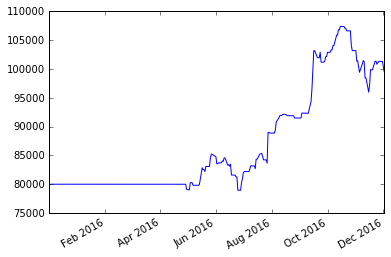

In [14]:
perf_manual['portfolio_value'].plot()

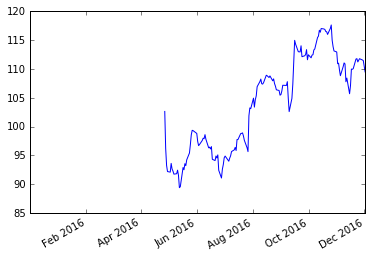

In [25]:
perf_manual['Price'].plot()

In [43]:
perf_manual['sharpe'][-1]

1.6696233520115509

In [47]:
perf_manual['alpha'][-1]

0.21335388827573487

In [48]:
perf_manual['max_drawdown'][-1]

-0.10626992138004357

In [49]:
perf_manual['sortino'][-1]

3.1015798034998912

In [51]:
perf_manual['algo_volatility'][-1]

0.13521892767263224

In [54]:
perf_manual[['Price','status','cash','PnL','portfolio_value']][pd.isnull(perf_manual['status'])==0]

,Price,status,cash,PnL,portfolio_value
2016-04-26 20:00:00,102.632739,--,80000.000000,0.000000,80000.000000
2016-04-27 20:00:00,96.210203,buy,80000.000000,0.000000,80000.000000
2016-04-28 20:00:00,93.269411,--,2486.886958,-6.232501,79993.767499
2016-04-29 20:00:00,92.197345,--,2486.886958,-897.119347,79102.880653
2016-05-02 20:00:00,92.098992,sell,2486.886958,-978.850690,79021.149310
2016-05-03 20:00:00,93.613649,--,80273.596776,273.596776,80273.596776
2016-05-04 20:00:00,92.639944,buy,80273.596776,273.596776,80273.596776
2016-05-05 20:00:00,92.263917,sell,366.549649,267.101771,80267.101771
2016-05-06 20:00:00,91.749363,--,79815.003004,-184.996996,79815.003004
2016-05-09 20:00:00,91.818630,--,79815.003004,-184.996996,79815.003004
